### 1. Importação dos módulos

In [ ]:
import kagglehub
import os

import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, classification_report
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier, plot_importance

# Encoders
from sklearn.preprocessing import *

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### 2. Importação do dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("chilledwanker/loan-approval-prediction")
filemname = 'credit_risk_dataset.csv'

df_emprestimo = pd.read_csv(os.path.join(path, filemname))

In [3]:
df_emprestimo.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### 3. Reordenando o dataset

In [4]:
# Rearranjando para colocar o target no local certo
loan_status = df_emprestimo.pop('loan_status')
df_emprestimo.insert(len(df_emprestimo.columns), 'loan_status', loan_status)

# Renomeando as colunas para melhor entendimento do problema

df_emprestimo.columns = ['idade', 'renda', 'moradia', 'tempo_empregado', 'motivo_emp', 'risco_emp',
                          'valor_emp', 'taxa_juros', 'emp/renda', 'hist_inadimplencia', 'tempo_emp_hist', 'sts_emp']

### 4. Limpando o dataset

In [5]:
# Começando as análises por colunas, iremos trabalhar olhando para o dataset no geral
df_emprestimo.isna().sum()

idade                    0
renda                    0
moradia                  0
tempo_empregado        895
motivo_emp               0
risco_emp                0
valor_emp                0
taxa_juros            3116
emp/renda                0
hist_inadimplencia       0
tempo_emp_hist           0
sts_emp                  0
dtype: int64

Percebe-se que há uma necessidade de tratamento para as colunas de taxa de juros e de tempo empregado, esses valores serão tratados no futuro.

In [6]:
# Realizando uma Análise Exploratória dos Dados
df_emprestimo.describe()

,idade,renda,tempo_empregado,valor_emp,taxa_juros,emp/renda,tempo_emp_hist,sts_emp
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.170203,5.804211,0.218164
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.106782,4.055001,0.413006
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.230000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Nota-se que existem alguns dados que estão incorretos, como uma idade máxima de 144 anos e tempo empregado de 123 anos, iremos nos aprofundar nesses valores. 

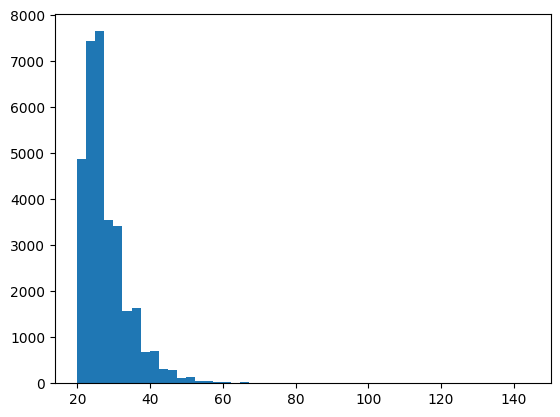

In [7]:
plt.hist(df_emprestimo.idade, bins = 50);

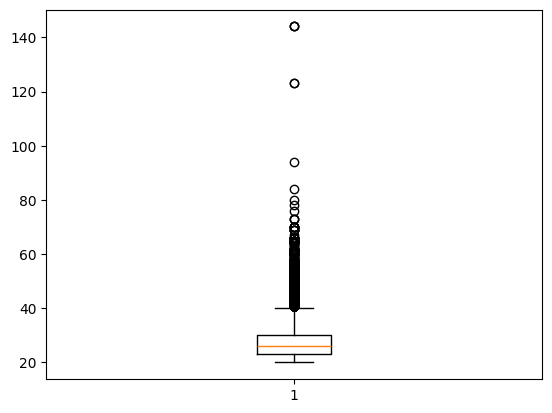

In [8]:
plt.boxplot(df_emprestimo.idade);

In [9]:
# Tratando os outliers
df_emprestimo[df_emprestimo['idade']>90]

,idade,renda,moradia,tempo_empregado,motivo_emp,risco_emp,valor_emp,taxa_juros,emp/renda,hist_inadimplencia,tempo_emp_hist,sts_emp
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4,0
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27,0


Como são poucos dados, a saída para esses casos será excluí-los do dataset. Temos, dentre esses valores, o valor da renda máxima que foge muito da média e da banda de 75%
Também pode-se notar que a distribuição segue conforme se espera para uma distribuição de idades.

In [10]:
df_emprestimo = df_emprestimo[df_emprestimo['idade']< 95].reset_index(drop=True)

In [11]:
df_emprestimo.describe()

,idade,renda,tempo_empregado,valor_emp,taxa_juros,emp/renda,tempo_emp_hist,sts_emp
count,32576.000000,3.257600e+04,31681.000000,32576.000000,29461.000000,32576.000000,32576.000000,32576.000000
mean,27.718044,6.588214e+04,4.789527,9589.117755,11.011547,0.170212,5.803966,0.218197
std,6.204990,5.253499e+04,4.142706,6321.886846,3.240623,0.106778,4.053791,0.413029
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.230000,8.000000,0.000000
max,94.000000,2.039784e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


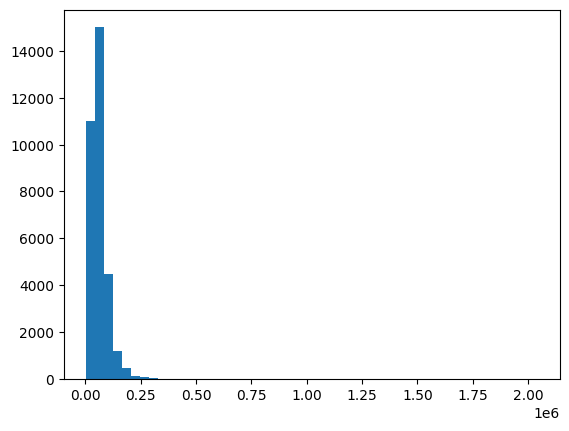

In [12]:
plt.hist(df_emprestimo['renda'], bins=50);

In [13]:
df_emprestimo[df_emprestimo['tempo_empregado'] >20].sort_values(ascending=False, by='tempo_empregado').head(5)

,idade,renda,moradia,tempo_empregado,motivo_emp,risco_emp,valor_emp,taxa_juros,emp/renda,hist_inadimplencia,tempo_emp_hist,sts_emp
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
208,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4,0
32350,78,48000,RENT,41.0,MEDICAL,A,3000,7.51,0.06,N,25,0
32510,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0.19,N,23,0
32423,58,49000,MORTGAGE,34.0,MEDICAL,D,7500,13.55,0.15,Y,24,1


Percebe-se que as duas primeiras linhas estão com dados incosistentes, temos duas pessoas com mais tempo empregado do que tem de idade, iremos aprofundar para essa faixa

In [14]:
df_emprestimo[df_emprestimo['idade']<23].groupby('idade')['tempo_empregado'].value_counts()

idade  tempo_empregado
20     4.0                  10
       3.0                   3
       0.0                   1
       1.0                   1
21     5.0                 434
       2.0                 185
       0.0                 183
       3.0                 143
       1.0                  87
       4.0                  81
       6.0                  64
       123.0                 1
22     6.0                1084
       0.0                 473
       2.0                 441
       3.0                 415
       1.0                 356
       4.0                 317
       5.0                 272
       7.0                 160
       123.0                 1
Name: count, dtype: int64

Apesar de os valores serem totalmente incosistentes, entende-se que, por serem dados sintéticos, para garantir a anonimatização do dataset, não há a necessidade de tratamento. Apenas os valores muito acima de 123 serão trocados.

In [15]:
st.mode(df_emprestimo['tempo_empregado'])

ModeResult(mode=0.0, count=4105)

Também, será realizado o tratamento para os valores nulos que foram apresentados anteriormente.

In [16]:
df_emprestimo['tempo_empregado']= df_emprestimo['tempo_empregado'].replace(123, 0)
df_emprestimo['tempo_empregado']= df_emprestimo['tempo_empregado'].fillna(0)

In [17]:
df_emprestimo.isna().sum()

idade                    0
renda                    0
moradia                  0
tempo_empregado          0
motivo_emp               0
risco_emp                0
valor_emp                0
taxa_juros            3115
emp/renda                0
hist_inadimplencia       0
tempo_emp_hist           0
sts_emp                  0
dtype: int64

In [18]:
# Checando os valores novos:
df_emprestimo.describe()

,idade,renda,tempo_empregado,valor_emp,taxa_juros,emp/renda,tempo_emp_hist,sts_emp
count,32576.000000,3.257600e+04,32576.000000,32576.000000,29461.000000,32576.000000,32576.000000,32576.000000
mean,27.718044,6.588214e+04,4.650387,9589.117755,11.011547,0.170212,5.803966,0.218197
std,6.204990,5.253499e+04,4.055226,6321.886846,3.240623,0.106778,4.053791,0.413029
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.230000,8.000000,0.000000
max,94.000000,2.039784e+06,41.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [19]:
df_emprestimo['moradia'].value_counts()

moradia
RENT        16443
MORTGAGE    13442
OWN          2584
OTHER         107
Name: count, dtype: int64

In [20]:
# Trocando os valores para portugues para facilitar a visualização

moradia_replace = {
    'RENT': 'aluguel',
    'MORTGAGE': 'financiamento',
    'OWN': 'propria',
    'OTHER': 'outro'
}

df_emprestimo['moradia'] = df_emprestimo['moradia'].replace(moradia_replace)

In [21]:
df_emprestimo['sts_emp'].value_counts()

sts_emp
0    25468
1     7108
Name: count, dtype: int64

In [22]:
df_emprestimo.groupby('sts_emp')['moradia'].value_counts(normalize=True).unstack()

moradia,aluguel,financiamento,outro,propria
sts_emp,,,,
0,0.441770,0.461442,0.002906,0.093883
1,0.730445,0.237760,0.004643,0.027153


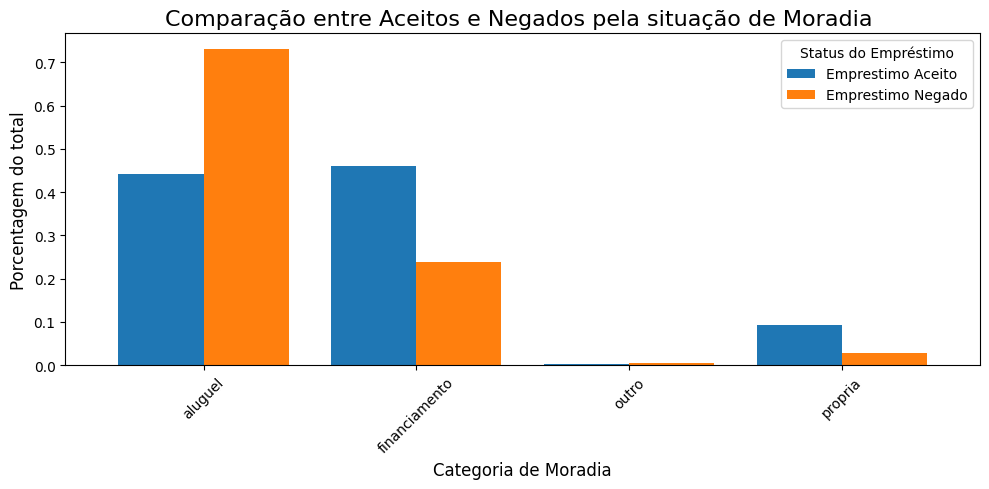

In [23]:
df = df_emprestimo.groupby('sts_emp')['moradia'].value_counts(normalize=True).unstack()

# Configurando o gráfico
ax = df.T.plot(kind='bar', figsize=(10, 5), width=0.8)

# Personalizando o gráfico
ax.set_title("Comparação entre Aceitos e Negados pela situação de Moradia ", fontsize=16)
ax.set_xlabel("Categoria de Moradia", fontsize=12)
ax.set_ylabel("Porcentagem do total", fontsize=12)
ax.legend(["Emprestimo Aceito", "Emprestimo Negado"], title="Status do Empréstimo")
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

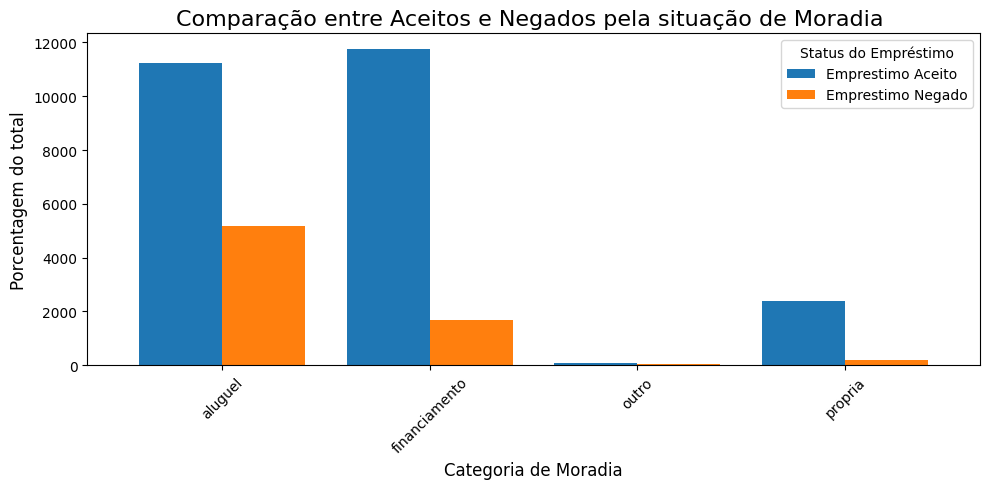

In [24]:
df3 = df_emprestimo.groupby('sts_emp')['moradia'].value_counts().unstack()

# Configurando o gráfico
ax = df3.T.plot(kind='bar', figsize=(10, 5), width=0.8)

# Personalizando o gráfico
ax.set_title("Comparação entre Aceitos e Negados pela situação de Moradia ", fontsize=16)
ax.set_xlabel("Categoria de Moradia", fontsize=12)
ax.set_ylabel("Porcentagem do total", fontsize=12)
ax.legend(["Emprestimo Aceito", "Emprestimo Negado"], title="Status do Empréstimo")
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

É possível notar que essa é uma feature importante para determinar se o empréstimo será aceito ou não. Será feita a substituição para o motivo e análise novamente.

In [25]:
df_emprestimo['motivo_emp'].value_counts()

motivo_emp
EDUCATION            6451
MEDICAL              6071
VENTURE              5717
PERSONAL             5520
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

In [26]:
motivo_emp_replace = {
    'EDUCATION': 'educacao',
    'MEDICAL': 'saude',
    'VENTURE': 'investimento',
    'PERSONAL': 'pessoal',
    'DEBTCONSOLIDATION': 'consolidacao_dividas',
    'HOMEIMPROVEMENT': 'reforma'   
}

df_emprestimo['motivo_emp'] = df_emprestimo['motivo_emp'].replace(motivo_emp_replace)

In [27]:
df_emprestimo.groupby('sts_emp')['motivo_emp'].value_counts(normalize=True).unstack()

motivo_emp,consolidacao_dividas,educacao,investimento,pessoal,reforma,saude
sts_emp,,,,,,
0,0.146144,0.209675,0.191220,0.173630,0.104602,0.174729
1,0.209623,0.156303,0.119162,0.154474,0.132386,0.228053


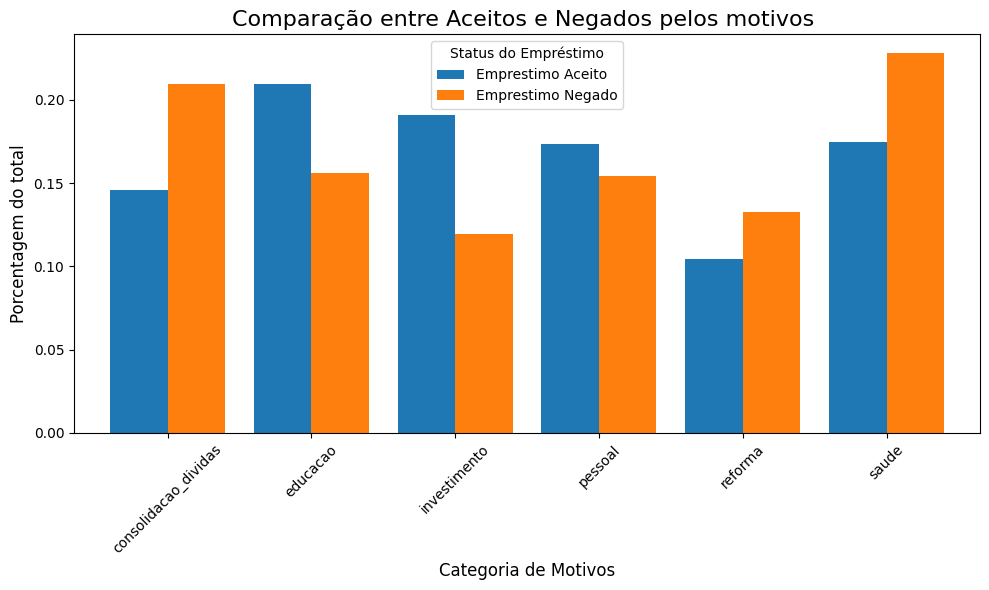

In [28]:
df2 = df_emprestimo.groupby('sts_emp')['motivo_emp'].value_counts(normalize=True).unstack()

# Configurando o gráfico
ax = df2.T.plot(kind='bar', figsize=(10, 6), width=0.8)

# Personalizando o gráfico
ax.set_title("Comparação entre Aceitos e Negados pelos motivos ", fontsize=16)
ax.set_xlabel("Categoria de Motivos", fontsize=12)
ax.set_ylabel("Porcentagem do total", fontsize=12)
ax.legend(["Emprestimo Aceito", "Emprestimo Negado"], title="Status do Empréstimo")
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()

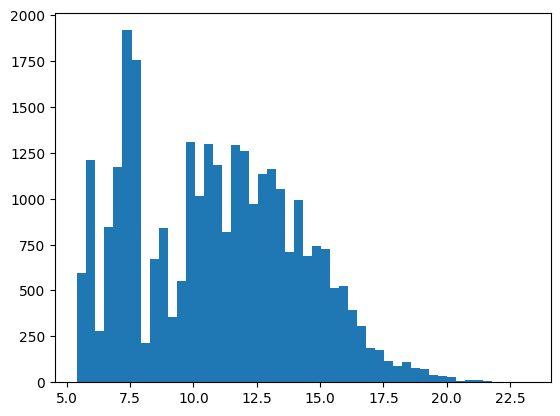

In [29]:
plt.hist(df_emprestimo['taxa_juros'], bins=50);

Como não há uma distribuição muito clara das taxas de juros, precisa-se de uma maneira mais assertiva para preencher os valores faltantes. Será utilizada uma abordagem de clusterização dos clientes para buscar taxas de juros mais condizentes para cada cluster. Há também uma avaliação importante que é a % emp/renda, que influencia na taxa.

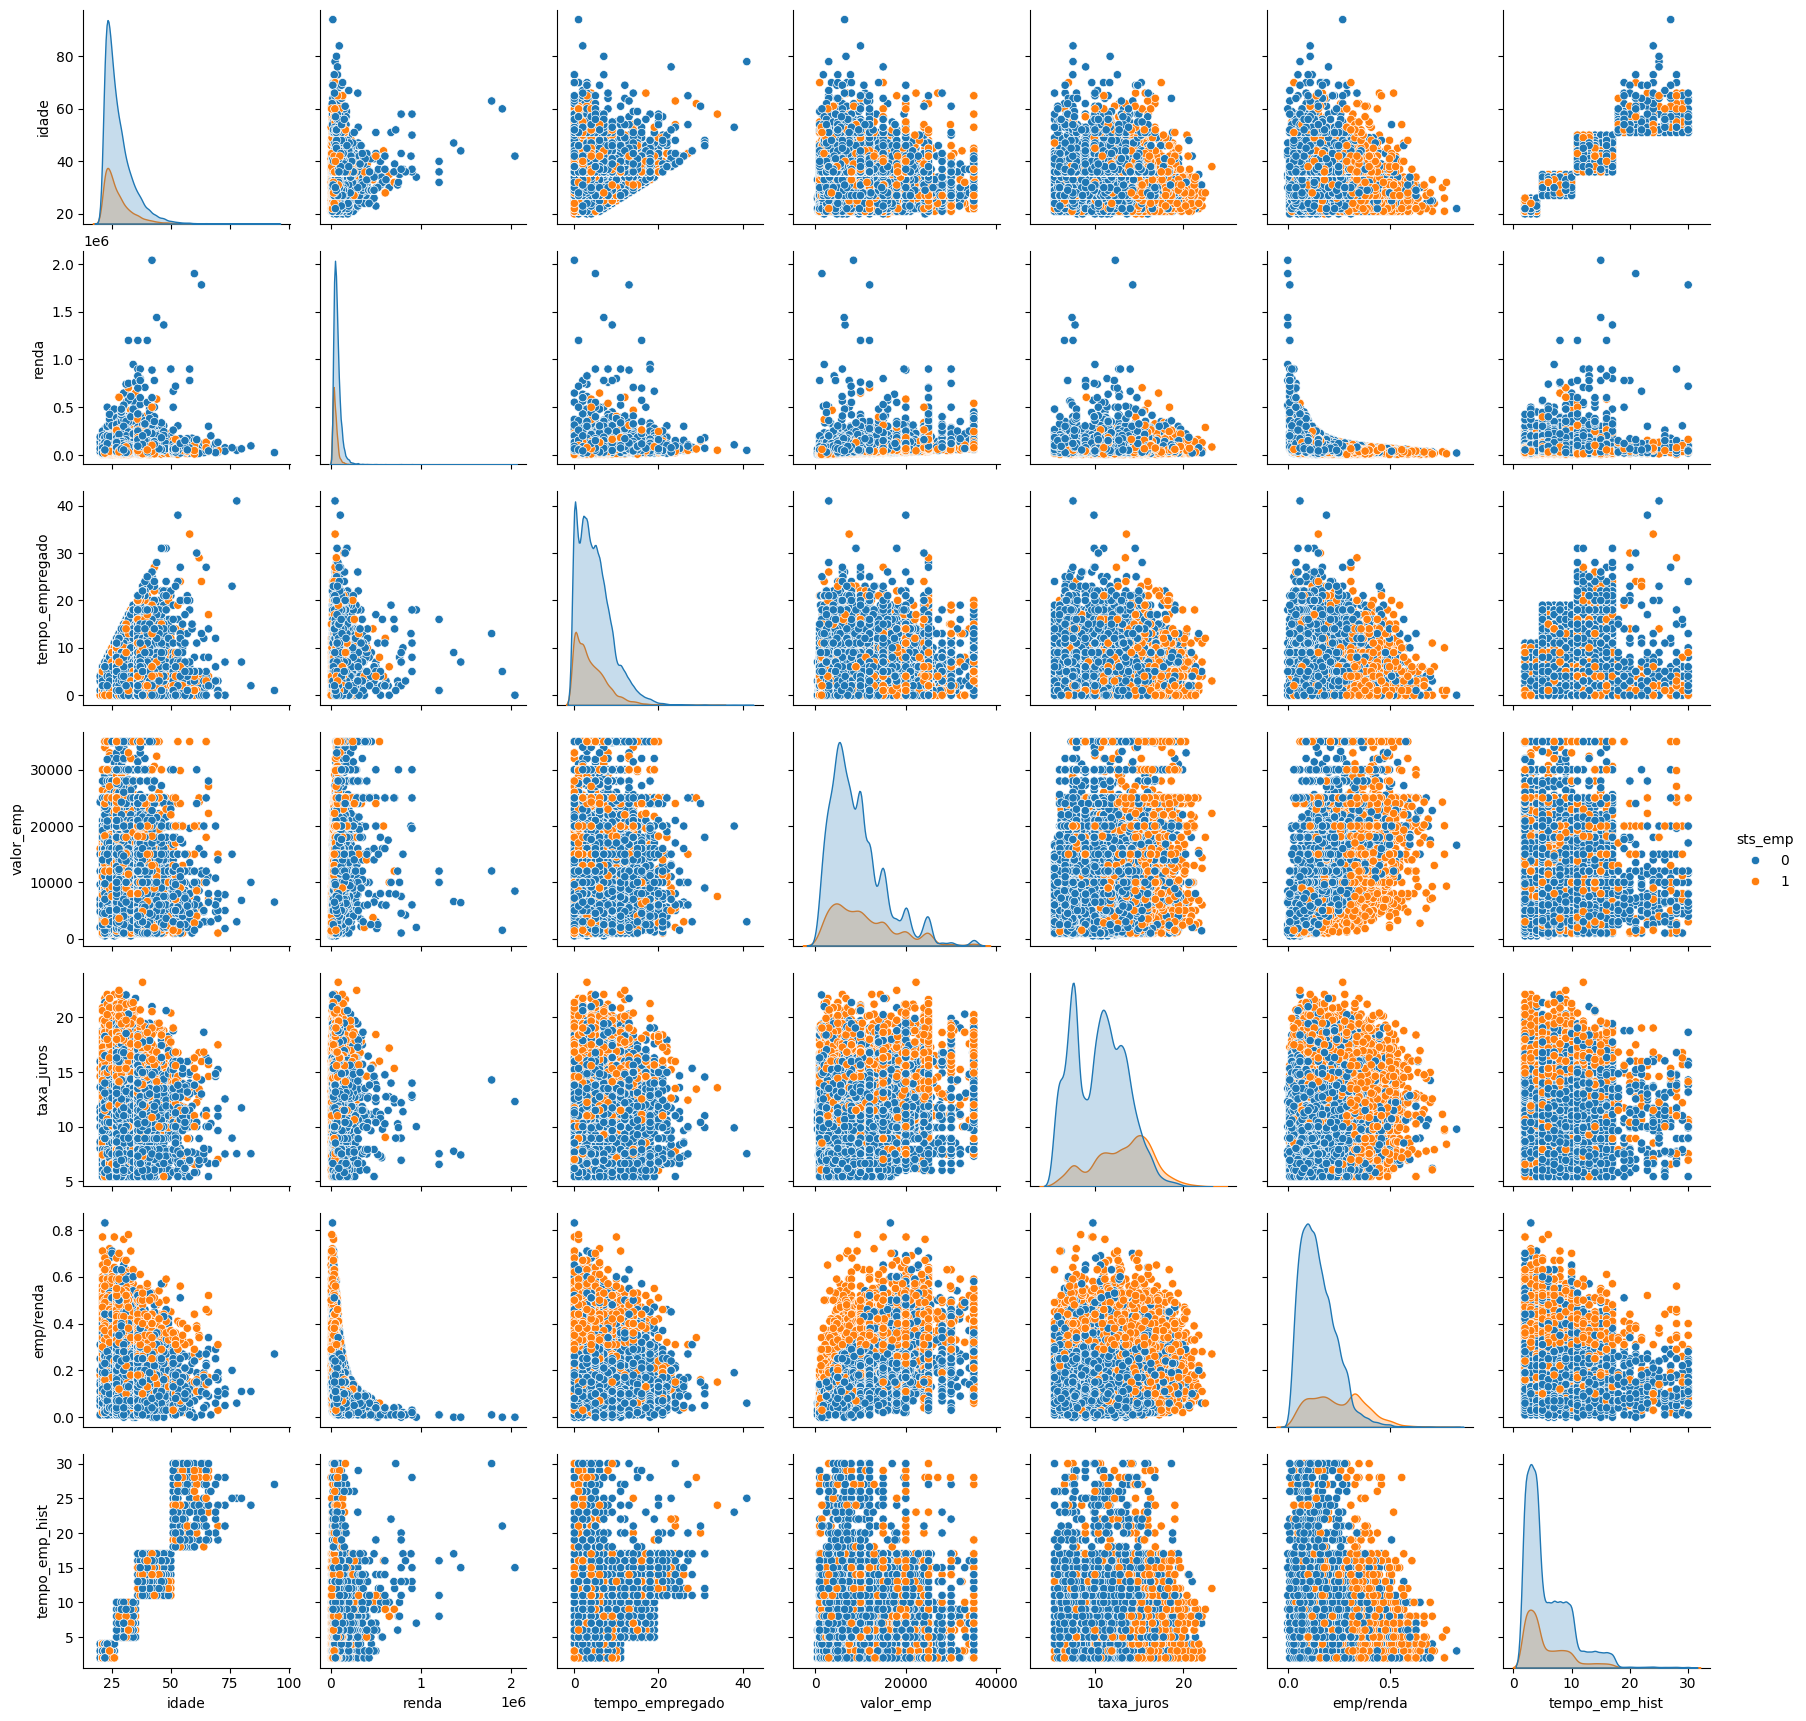

In [30]:
sns.pairplot(df_emprestimo, hue='sts_emp');

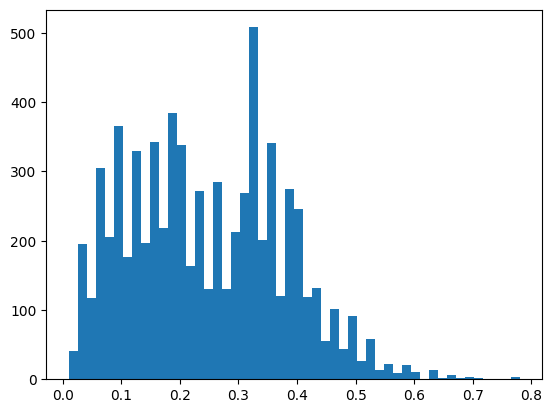

In [31]:
plt.hist(df_emprestimo['emp/renda'][df_emprestimo['sts_emp'] == 1], bins=50);

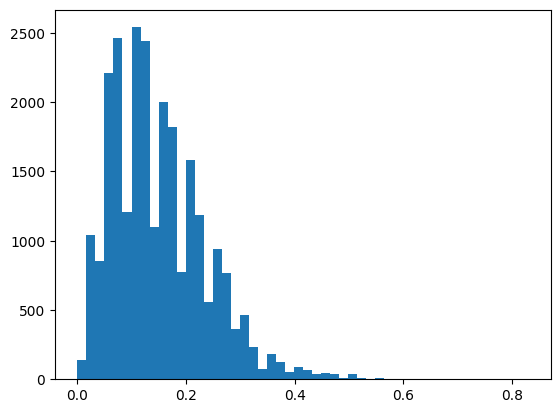

In [32]:
plt.hist(df_emprestimo['emp/renda'][df_emprestimo['sts_emp'] == 0], bins=50);

Pode-se notar que não há uma relação clara entre a aprovação e a % de emp/renda, bem como uma distribuição normal dos valores para que seja possível imputar diretamente de acordo com uma distribuição. 

In [33]:
df_emprestimo_cluster = df_emprestimo.drop(columns=['sts_emp', 'taxa_juros'])

In [34]:
df_emprestimo_cluster.head()

,idade,renda,moradia,tempo_empregado,motivo_emp,risco_emp,valor_emp,emp/renda,hist_inadimplencia,tempo_emp_hist
0,22,59000,aluguel,0.0,pessoal,D,35000,0.59,Y,3
1,21,9600,propria,5.0,educacao,B,1000,0.10,N,2
2,25,9600,financiamento,1.0,saude,C,5500,0.57,N,3
3,23,65500,aluguel,4.0,saude,C,35000,0.53,N,2
4,24,54400,aluguel,8.0,saude,C,35000,0.55,Y,4


In [35]:
cat_num = list(df_emprestimo_cluster.select_dtypes(include='number'))
cat_hot = list(df_emprestimo_cluster.select_dtypes(exclude='number'))

In [36]:
s_scaler = StandardScaler()
min_max = MinMaxScaler()
one_encoder = OneHotEncoder(sparse_output=False)

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', min_max, cat_num),
        ('cat', one_encoder, cat_hot)
    ]
)

In [38]:
x_prep = preprocessor.fit_transform(df_emprestimo_cluster)

In [39]:
pca = PCA(n_components= 0.7)

In [40]:
x_red = pca.fit_transform(x_prep)

In [41]:
kmeans = KMeans(n_clusters=4)

In [42]:
kmeans.fit(x_red)

KMeans(n_clusters=4)

In [43]:
kmeans.predict(x_red)

array([0, 1, 1, ..., 3, 1, 3])

In [44]:
labels_clusters = kmeans.labels_

In [45]:
len(labels_clusters)

32576

In [46]:
labels_series = pd.Series(labels_clusters, name = "label")

In [47]:
labels_series.shape[0]

32576

In [48]:
df_emprestimo_cluster.shape[0]

32576

In [49]:
df_cluster_f = pd.concat([df_emprestimo_cluster, labels_series], axis=1)

In [50]:
df_cluster_f

,idade,renda,moradia,tempo_empregado,motivo_emp,risco_emp,valor_emp,emp/renda,hist_inadimplencia,tempo_emp_hist,label
0,22,59000,aluguel,0.0,pessoal,D,35000,0.59,Y,3,0
1,21,9600,propria,5.0,educacao,B,1000,0.10,N,2,1
2,25,9600,financiamento,1.0,saude,C,5500,0.57,N,3,1
3,23,65500,aluguel,4.0,saude,C,35000,0.53,N,2,3
4,24,54400,aluguel,8.0,saude,C,35000,0.55,Y,4,0
...,...,...,...,...,...,...,...,...,...,...,...
32571,57,53000,financiamento,1.0,pessoal,C,5800,0.11,N,30,1
32572,54,120000,financiamento,4.0,pessoal,A,17625,0.15,N,19,2
32573,65,76000,aluguel,3.0,reforma,B,35000,0.46,N,28,3
32574,56,150000,financiamento,5.0,pessoal,B,15000,0.10,N,26,1


In [51]:
silhouette_score(x_red, labels_series)

0.24408279915094

In [52]:
x_red

array([[ 1.09592191,  0.77004348, -0.02972505, ...,  0.27279453,
        -0.74449162, -0.56531667],
       [-0.11081219, -0.46624042,  0.63894233, ..., -0.03905654,
         0.31117003, -0.26043846],
       [-0.42778202,  0.56960379,  0.23028626, ..., -0.77862324,
         0.33976181, -0.09222662],
       ...,
       [ 0.47774702, -0.7230248 ,  0.53919297, ...,  0.05861393,
        -0.08969501,  0.05555687],
       [-0.71458728, -0.15199136,  0.8975623 , ...,  0.16472967,
        -0.66070936, -0.5422015 ],
       [ 0.54841154, -0.80121186,  0.45730173, ..., -0.67525167,
         0.24878784, -0.10547684]])

In [53]:
X_df = pd.DataFrame(x_red, columns = [f"X{i+1}" for i in range(x_red.shape[1])])
X_df.head()

,X1,X2,X3,X4,X5,X6,X7
0,1.095922,0.770043,-0.029725,-0.209457,0.272795,-0.744492,-0.565317
1,-0.110812,-0.466240,0.638942,0.861844,-0.039057,0.311170,-0.260438
2,-0.427782,0.569604,0.230286,-0.403134,-0.778623,0.339762,-0.092227
3,0.754913,-0.017879,-0.128178,-0.386132,-0.703647,0.309536,-0.091538
4,1.248908,0.956836,-0.035512,-0.423203,-0.686850,0.297819,-0.109227


In [54]:
dbscan = DBSCAN()
dbscan.fit(X_df)

DBSCAN()

In [55]:
dbscan.labels_

array([ 0,  1,  2, ..., 21, 65,  7], dtype=int64)

In [56]:
def plot_dbscan(X_df, eps, min_pts):
     # Instanciamento e fit do modelo
    dbscan = DBSCAN(eps = eps, min_samples = min_pts)
    dbscan.fit(X_df)

    # ========================================
    # estruturação dos resultados
    labels_clusters = dbscan.labels_
    labels_series = pd.Series(labels_clusters, name="label")

    df_result = pd.concat([X_df, labels_series], axis=1)
    n_clusters = pd.Series(labels_clusters).nunique()

    # ========================================
    print(f"DBSCAN com eps={eps} e minPts={min_pts}\nNúmero de clusters: {n_clusters}")
    sns.scatterplot(data=df_result, x="X1", y="X2", hue="label", palette="tab10")
    plt.legend(loc='lower left', ncol=3, bbox_to_anchor=(1.05, 0))
    plt.show()

    lab_counts = (pd.Series(labels_clusters).value_counts())

    print("Quantidade máxima de pontos em cada clusters:", round(pd.Series(lab_counts).max(), 2))
    print("Quantidade média de pontos em cada clusters:", round(pd.Series(lab_counts).mean(), 2))
    print("Quantidade mínima de pontos em cada clusters:", round(pd.Series(lab_counts).min(), 2))
    print("Desvio padrão da quantidade média de pontos em cada clusters:", round(pd.Series(lab_counts).std(), 2))


    return df_result, n_clusters

DBSCAN com eps=0.7 e minPts=250
Número de clusters: 31


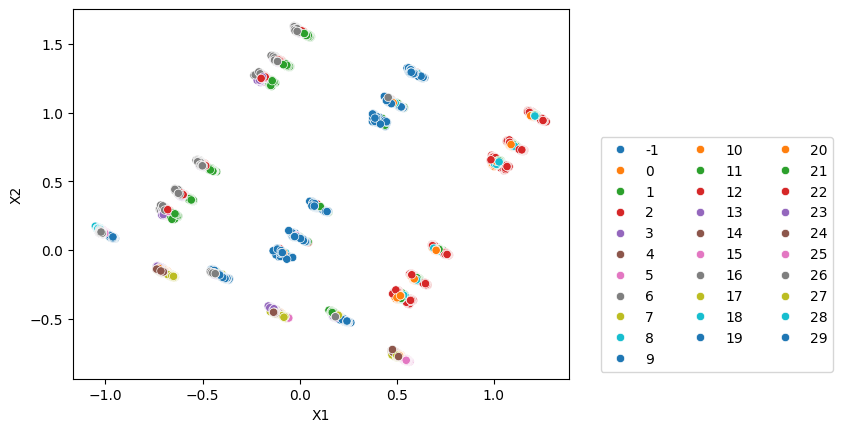

Quantidade máxima de pontos em cada clusters: 2024
Quantidade média de pontos em cada clusters: 1050.84
Quantidade mínima de pontos em cada clusters: 361
Desvio padrão da quantidade média de pontos em cada clusters: 466.87


In [57]:
df_result, n_clusters = plot_dbscan(X_df,
                                   eps = 0.7,
                                   min_pts = 250)

DBSCAN com eps=0.1 e minPts=250
Número de clusters: 37


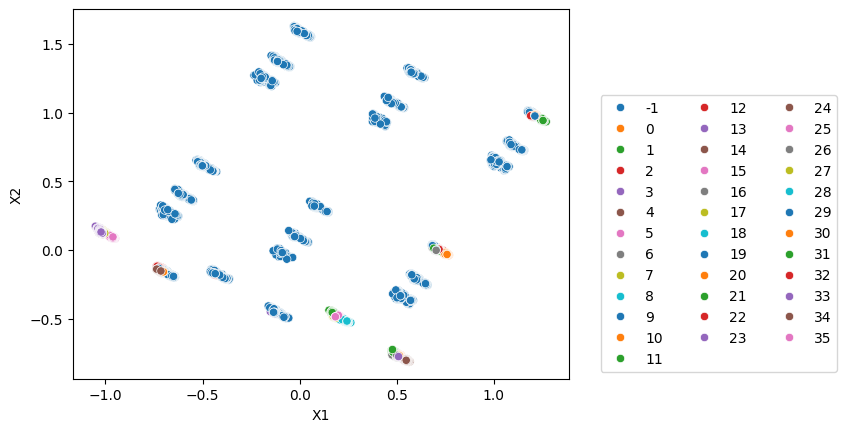

Quantidade máxima de pontos em cada clusters: 9217
Quantidade média de pontos em cada clusters: 880.43
Quantidade mínima de pontos em cada clusters: 255
Desvio padrão da quantidade média de pontos em cada clusters: 1436.33
DBSCAN com eps=0.2 e minPts=250
Número de clusters: 41


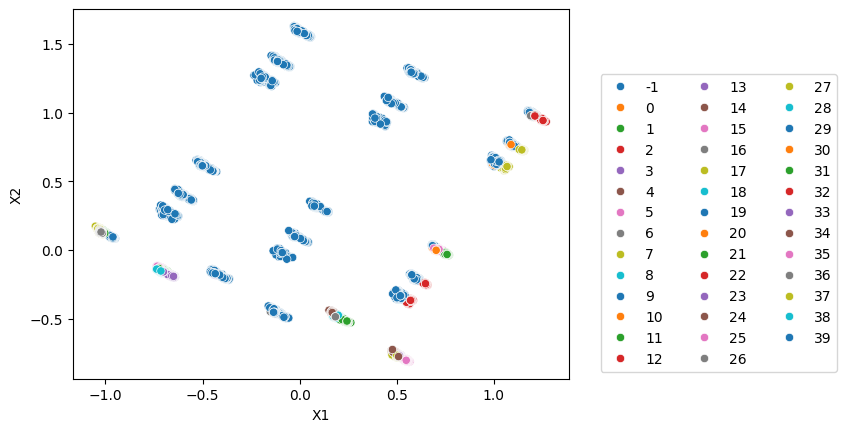

Quantidade máxima de pontos em cada clusters: 8152
Quantidade média de pontos em cada clusters: 794.54
Quantidade mínima de pontos em cada clusters: 255
Desvio padrão da quantidade média de pontos em cada clusters: 1212.98
DBSCAN com eps=0.30000000000000004 e minPts=250
Número de clusters: 51


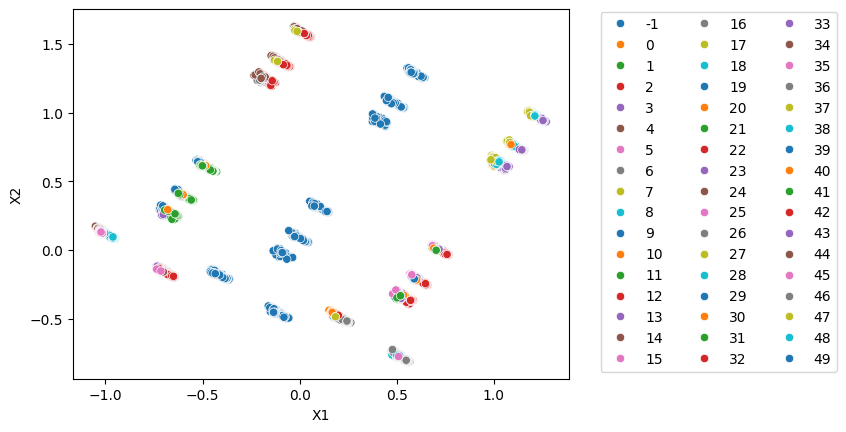

Quantidade máxima de pontos em cada clusters: 2112
Quantidade média de pontos em cada clusters: 638.75
Quantidade mínima de pontos em cada clusters: 262
Desvio padrão da quantidade média de pontos em cada clusters: 330.81
DBSCAN com eps=0.4 e minPts=250
Número de clusters: 51


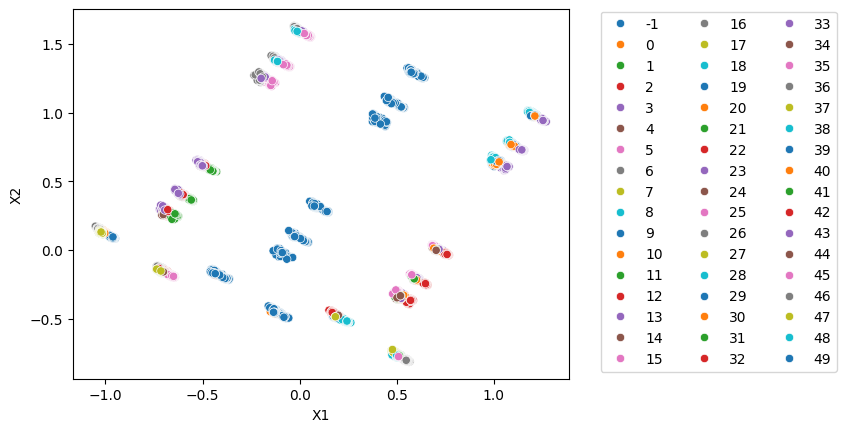

Quantidade máxima de pontos em cada clusters: 2112
Quantidade média de pontos em cada clusters: 638.75
Quantidade mínima de pontos em cada clusters: 262
Desvio padrão da quantidade média de pontos em cada clusters: 330.81
DBSCAN com eps=0.5 e minPts=250
Número de clusters: 51


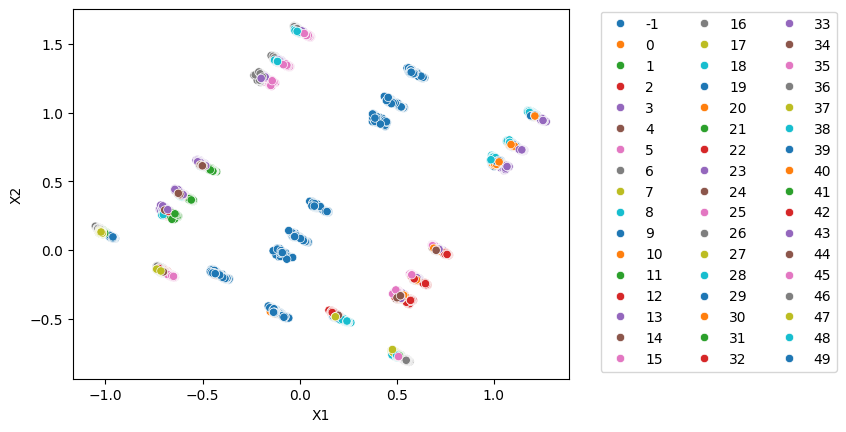

Quantidade máxima de pontos em cada clusters: 2112
Quantidade média de pontos em cada clusters: 638.75
Quantidade mínima de pontos em cada clusters: 262
Desvio padrão da quantidade média de pontos em cada clusters: 330.81


In [58]:
# Variando o eps:
eps_values = np.linspace(0.1, 0.5, 5)
n_clusters = []

for eps in eps_values:
    _, n = plot_dbscan(X_df, eps = eps, min_pts = 250)
    n_clusters.append(n)

In [63]:
df_cluster_f = pd.concat([df_cluster_f, df_emprestimo['taxa_juros'].reset_index(drop=True)], axis=1)

In [64]:
df_cluster_f.head()

,idade,renda,moradia,tempo_empregado,motivo_emp,risco_emp,valor_emp,emp/renda,hist_inadimplencia,tempo_emp_hist,label,taxa_juros
0,22,59000,aluguel,0.0,pessoal,D,35000,0.59,Y,3,0,16.02
1,21,9600,propria,5.0,educacao,B,1000,0.10,N,2,1,11.14
2,25,9600,financiamento,1.0,saude,C,5500,0.57,N,3,1,12.87
3,23,65500,aluguel,4.0,saude,C,35000,0.53,N,2,3,15.23
4,24,54400,aluguel,8.0,saude,C,35000,0.55,Y,4,0,14.27


In [68]:
df_cluster_f.groupby('label')['taxa_juros'].mean()

label
0    14.475589
1    12.045711
2     7.433804
3    12.300782
Name: taxa_juros, dtype: float64

In [69]:
df_cluster_f.groupby('label')['taxa_juros'].std()

label
0    1.714895
1    2.053885
2    1.413710
3    2.129958
Name: taxa_juros, dtype: float64

In [70]:
df_cluster_f.groupby('label')['taxa_juros'].mean()

label
0    14.475589
1    12.045711
2     7.433804
3    12.300782
Name: taxa_juros, dtype: float64

In [71]:
df_cluster_f.groupby('risco_emp')['taxa_juros'].mean()

risco_emp
A     7.327651
B    10.995542
C    13.463649
D    15.361448
E    17.009455
F    18.609159
G    20.251525
Name: taxa_juros, dtype: float64

Percebeu-se que, filtrando pelo risco e analisando pela média, os valores da taxa de juros são mt mais assertivos de acordo com o risco.
Cria-se então uma variável para armazenar o dataframe resultante para poder preencher os valores nulos. 

In [72]:
var = (df_cluster_f.groupby('risco_emp')['taxa_juros'].mean())

In [73]:
# Preenchendo os valores nulos 

for i in range(var.shape[0]):
    mask = df_cluster_f['risco_emp'] == var.index[i]
    df_cluster_f.loc[mask] = df_cluster_f.loc[mask].fillna(var.iloc[i])

In [74]:
df_cluster_f['risco_emp'].value_counts()

risco_emp
A    10777
B    10448
C     6456
D     3626
E      964
F      241
G       64
Name: count, dtype: int64

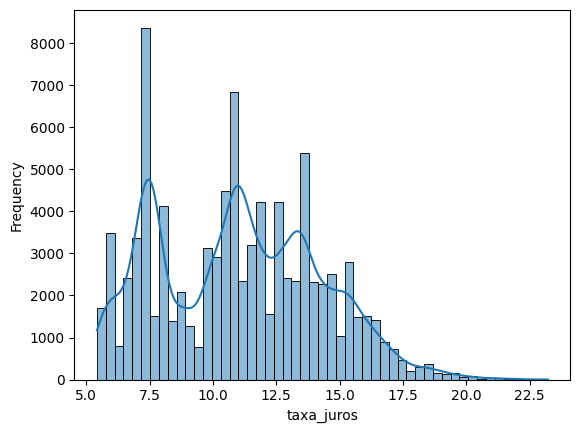

In [75]:
# Podemos ver pelo histograma que existem os picos correspondentes pelos riscos associados.
sns.histplot(df_cluster_f, x= 'taxa_juros', stat= 'frequency', kde=True);

In [76]:
df_final = pd.concat([df_cluster_f, df_emprestimo['sts_emp']], axis=1,)

In [77]:
df_final.head()

,idade,renda,moradia,tempo_empregado,motivo_emp,risco_emp,valor_emp,emp/renda,hist_inadimplencia,tempo_emp_hist,label,taxa_juros,sts_emp
0,22,59000,aluguel,0.0,pessoal,D,35000,0.59,Y,3,0,16.02,1
1,21,9600,propria,5.0,educacao,B,1000,0.10,N,2,1,11.14,0
2,25,9600,financiamento,1.0,saude,C,5500,0.57,N,3,1,12.87,1
3,23,65500,aluguel,4.0,saude,C,35000,0.53,N,2,3,15.23,1
4,24,54400,aluguel,8.0,saude,C,35000,0.55,Y,4,0,14.27,1


In [78]:
x, y = df_final.drop(columns=['sts_emp']), df_final['sts_emp']

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

In [80]:
cat_num = list(x.select_dtypes(include='number'))
cat_hot = list(x.select_dtypes(exclude='number'))

In [81]:
min_max = MinMaxScaler()
one_encoder = OneHotEncoder(sparse_output=False)

In [82]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', min_max, cat_num),
        ('cat', one_encoder, cat_hot)
    ]
)

In [83]:
pipe_xgb = Pipeline([
    ('pre_processador', preprocessor),
    ("XGB", XGBClassifier(random_state=42))
])

In [84]:
pipe_xgb.fit(x_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['idade', 'renda',
                                                   'tempo_empregado',
                                                   'valor_emp', 'emp/renda',
                                                   'tempo_emp_hist', 'label',
                                                   'taxa_juros']),
                                                 ('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['moradia', 'motivo_emp',
                                                   'risco_emp',
                                                   'hist_inadimplencia'])])),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callback...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [85]:
y_pred = pipe_xgb.predict(x_test)

In [86]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8080
           1       0.75      0.94      0.83      1693

    accuracy                           0.93      9773
   macro avg       0.87      0.94      0.90      9773
weighted avg       0.95      0.93      0.94      9773



In [ ]:
# Acessar o modelo do XGB no pipeline
xgb_model = pipe_xgb.named_steps["XGB"]

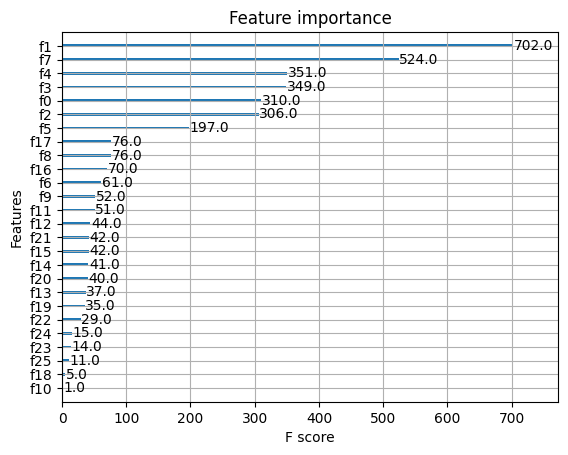

In [91]:
plot_importance(xgb_model);

In [92]:
# Acessar as transformações do ColumnTransformer
if isinstance(preprocessor, ColumnTransformer):
    features_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            features_names.extend(transformer.get_feature_names_out(columns))
        else:
            features_names.extend(columns)

In [93]:
features_names

['idade',
 'renda',
 'tempo_empregado',
 'valor_emp',
 'emp/renda',
 'tempo_emp_hist',
 'label',
 'taxa_juros',
 'moradia_aluguel',
 'moradia_financiamento',
 'moradia_outro',
 'moradia_propria',
 'motivo_emp_consolidacao_dividas',
 'motivo_emp_educacao',
 'motivo_emp_investimento',
 'motivo_emp_pessoal',
 'motivo_emp_reforma',
 'motivo_emp_saude',
 'risco_emp_A',
 'risco_emp_B',
 'risco_emp_C',
 'risco_emp_D',
 'risco_emp_E',
 'risco_emp_F',
 'risco_emp_G',
 'hist_inadimplencia_N',
 'hist_inadimplencia_Y']

In [94]:
# Obter as importâncias das variáveis
feature_importances = xgb_model.feature_importances_

# Associar as importâncias às colunas trasnformadas
importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
})

In [ ]:
# Ordenar pela importância
importance_df = importance_df.sort_values(by = "Importance", ascending=False)

In [ ]:
importance_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Feature,idade,renda,tempo_empregado,valor_emp,emp/renda,tempo_emp_hist,label,taxa_juros,moradia_aluguel,moradia_financiamento,moradia_outro,moradia_propria,motivo_emp_consolidacao_dividas,motivo_emp_educacao,motivo_emp_investimento,motivo_emp_pessoal,motivo_emp_reforma,motivo_emp_saude,risco_emp_A,risco_emp_B,risco_emp_C,risco_emp_D,risco_emp_E,risco_emp_F,risco_emp_G,hist_inadimplencia_N,hist_inadimplencia_Y
Importance,0.01091,0.029873,0.016523,0.008748,0.094111,0.007468,0.008403,0.049069,0.201952,0.023202,0.038415,0.058548,0.083724,0.011023,0.031898,0.008899,0.037809,0.057513,0.00861,0.017622,0.090054,0.055823,0.00957,0.008824,0.022891,0.008517,0.0
